# Ising-Style Marginalization Toy Example

This notebook demonstrates a minimal toy example for
marginalizing over per-datum binary offsets ($s_i \in \{\pm1\}$) by mapping
the problem to an Ising model. It accompanies the paper draft:

_Analytic Marginalization over Binary Variables in Physics Data_
by Marcus Högås & Edvard Mörtsell (2025).

We will:
1. Generate synthetic data $y_i = \theta + s_i \Delta + \varepsilon_i$.
2. Show the exact marginalized likelihood in the independent-noise (paramagnetic) case.
3. Introduce correlations and demonstrate the mean-field approximation.

## Key ingredients
- Residuals: $r_i(\theta) = y_i^{\rm obs} - \theta$.
- Magnetic field: $h_i = \Delta \sum_j C^{-1}_{ij} r_j$.
- Magnetic field shift: $\eta_i = \tfrac{1}{2}\ln\frac{p}{1-p}$
- Effective magnetic field: $\tilde{h}_i = h_i + \eta_i $
- Couplings: $J_{ij} = -\Delta C^{-1}_{ij} \Delta$.

We compare:
- **Baseline** Gaussian likelihood (ignores binary offsets).
- **Paramagnetic** (exact when data independent).
- **Mean-field** (good approximation when correlations exist).

Two cases:
- Case A: independent data points.
- Case B: correlated data points.

NB! The numerical routines implemented in this toy example are oftentimes "overkill" but have been
implemented for straightforward adaptation to more advanced models.

In [1]:
# ============================================================
# IMPORT PACKAGES
# ============================================================
import numpy as np
from scipy.linalg import cho_factor, cho_solve, cholesky
from scipy.special import logit, logsumexp
from scipy.optimize import newton_krylov
import matplotlib.pyplot as plt
import time
import emcee
import corner
import matplotlib.lines as mlines
from matplotlib.colors import LogNorm


In [2]:
# ============================================================
# SET PARAMETERS
# ============================================================
rng = np.random.default_rng(42) # random seed, for reproducibility


In [3]:
# ============================================================
# FUNCTIONS: GENERATING DATA
# Two cases: independent and correlated data points.
# Cholesky factorization is used for numerical stability and
# efficiency.
# ============================================================

### Independent data points ###
def generate_C_indep(N, sigma):
    """Return covariance matrix for independent data."""

    return sigma**2 * np.eye(N)

    
def generate_data_indep(N=100, theta_true=20.0, Delta=0.2, sigma=0.1, p=0.3):
    """
    Simulate data y = theta_true + s*Delta + noise, and precompute Cholesky factor of C.
    Returns:
        y        : (N,)
        s_true   : (N,)
        C        : (N,N)
        C_fac     : tuple (c, lower) from scipy.linalg.cho_factor, so we can reuse it.
    """
    
    s_true = rng.choice([-1, 1], size=N, p=[1-p, p]) # binary parameter
    C = generate_C_indep(N, sigma) # covariance matrix
    C_fac = cho_factor(C, lower=True, check_finite=True) # Cholesky factorization once; reuse everywhere
    eps = rng.multivariate_normal(mean=np.zeros(N), cov=C) # noise
    y = theta_true + Delta * s_true + eps
    
    return y, s_true, C, C_fac


### Correlated data points ###
def _random_positive_correlation(N, strength=0.5, k=None):
    """
    Build a random correlation matrix with positive off-diagonals.
    
    Construction:
      1) Draw Z with strictly positive entries (lognormal), shape (k, N).
      2) Form Gram matrix G = Z^T Z (SPD with positive entries).
      3) Normalize to correlation: R0 = G / sqrt(diag(G) * diag(G)^T).
      4) Shrink toward identity: R = (1 - s) I + s R0,  s in [0, 1).
         This keeps diag(R)=1 and all off-diagonals > 0 (unless s=0).
    
    Parameters
    ----------
    N : int
        Dimension.
    strength : float in [0, 1)
        Shrinkage toward the random positive-correlation matrix.
        0 -> identity (independent); values closer to 1 -> stronger positive correlations.
    k : int or None
        Latent dimension for the Gram construction. Larger k -> “rounder” correlations.
        Defaults to max(3, N//2).
    seed : int or None
        RNG seed.
    """

    if k is None:
        k = max(3, N // 2)

    # Z > 0 elementwise -> G has positive entries -> positive correlations after normalization
    Z = rng.lognormal(mean=0.0, sigma=1.0, size=(k, N))
    G = Z.T @ Z  # SPD

    d = np.sqrt(np.diag(G))
    R0 = G / (d[:, None] * d[None, :])  # correlation with diag=1 and positive off-diagonals

    # Shrink toward identity to control average correlation strength
    s = np.clip(strength, 0.0, 0.999)  # keep <1 to avoid degeneracy
    R = (1.0 - s) * np.eye(N) + s * R0
    
    return R


def generate_data_corr(N=100, theta_true=20.0, Delta=0.2, sigma=0.1, p=0.5, strength=0.5, k=None):
    """
    Simulate thermometer data with random, positive correlations.

    Model
    -----
        y_i = theta_true + s_i * Delta + eps_i,
        s_i ∈ {±1} with P(s_i=+1)=p,
        eps ~ N(0, C),  C = sigma^2 * R,
        R is a random correlation matrix with strictly positive off-diagonals.

    Parameters
    ----------
    N : int
        Number of thermometers.
    theta_true : float
        True ambient temperature.
    Delta : float
        Binary offset magnitude.
    sigma : float
        Marginal standard deviation of each sensor (kept fixed).
    p : float in (0, 1)
        Probability of +Δ.
    strength : float in [0, 1)
        Controls average off-diagonal correlation. 0 -> independent; ~1 -> strong positive correlations.
    k : int or None
        Latent dimension used to generate the random correlation (see above).
    
    Returns
    -------
    y : (N,) ndarray
        Simulated readings.
    s_true : (N,) ndarray
        Realized binary offsets.
    C : (N,N) ndarray
        Covariance matrix of the noise.
    C_fac : tuple
        Cholesky factorization of C (for cho_solve).
    """
    
    R = _random_positive_correlation(N, strength=strength, k=k)
    C = (sigma ** 2) * R

    try: # Cholesky (add tiny jitter if needed for numerical robustness)
        C_fac = cho_factor(C, lower=False, check_finite=True)
    except Exception:
        # rare: add a touch of jitter to the diagonal and retry
        jitter = 1e-12 * (np.trace(C) / N)
        C_fac = cho_factor(C + jitter * np.eye(N), lower=False, check_finite=True)

    # Binary offsets and noise
    s_true = rng.choice([-1, 1], size=N, p=[1 - p, p])
    eps = rng.multivariate_normal(mean=np.zeros(N), cov=C)
    y = theta_true + Delta * s_true + eps
    
    return y, s_true, C, C_fac



In [4]:
# ============================================================
# FUNCTIONS: UTILITIES
# ============================================================

### Helpers that use the Cholesky factor ###
def logdet_from_cholesky(C_fac):
    """
    Given cho_factor(C) = (L, True), return log(det(C)).
    The diagonal of the factor squared gives eigenvalues product; logdet = 2*sum(log(diag)).
    """
    
    L, _lower = C_fac
    
    return 2.0 * np.sum(np.log(np.diag(L)))


def C_inv_dot(C_fac, v):
    """Compute C^{-1} v using the cached Cholesky factor."""
    return cho_solve(C_fac, v, check_finite=False)


def trace_C_inv(C_fac):
    """
    Compute Tr(C^{-1}) using solves against the identity.
    For pedagogical N (~100-300) this is fine. For large N, use Hutchinson’s trick.
    """
    
    N = C_fac[0].shape[0]
    I = np.eye(N)
    X = cho_solve(C_fac, I, check_finite=False) # Solve C X = I  -> X = C^{-1}
    
    return float(np.trace(X))


def cov_to_corr(C):
    """Convert covariance matrix to correlation matrix"""
    
    stddev = np.sqrt(np.diag(C))
    
    return C / np.outer(stddev, stddev)
    

In [5]:
# ============================================================
# FUNCTIONS: ISING
# ============================================================

def field_h(y, C_fac, Delta, theta):
    """h = Δ * C^{-1} r(θ)."""
    return Delta * C_inv_dot(C_fac, residual(y, theta))


def J_dot(C_fac, Delta, vec):
    """Apply J to a vector without forming J explicitly: J v = -(Δ^2) * C^{-1} v."""
    return -(Delta**2) * C_inv_dot(C_fac, vec)


def solve_mean_field_u(h_tilde, C_fac, Delta, u0=None, tol=1e-10, maxiter=300, homotopy=True):
    """
    Solve the mean-field self-consistency equation
        m = tanh(h_tilde + J m),   with  J = -Δ^2 C^{-1},
    using a reparameterization m = tanh(u), with warm start.

    Why reparameterize?
    -------------------
    - In terms of u, the equation becomes
          G(u) = u - h - J tanh(u) = 0,
      which is an unconstrained root-finding problem in ℝ^N.
    - The mapping m = tanh(u) automatically enforces |m_i| < 1,
      so we avoid numerical instabilities near the boundaries.

    Solver strategy
    ---------------
    - We use SciPy's `newton_krylov` (a robust quasi-Newton method for large systems).
    - A warm start is possible via u0 (very useful when scanning over θ).
    - If the direct solve fails (e.g. very steep tanh), we optionally
      use a simple homotopy/continuation: gradually increase the
      "strength" of h and J from s=0.2 up to 1.0, solving intermediate
      problems to guide convergence.

    Parameters
    ----------
    h_tilde  : array_like
        Effective magnetic field.
    C_fac    : tuple
        Cholesky factorization of the covariance matrix C.
    Delta    : float
        Shift magnitude (controls steepness of tanh transition).
    u0       : array_like or None
        Warm start for u; if None, starts from zero.
    tol      : float
        Solver tolerance.
    maxiter  : int
        Maximum number of iterations per Newton-Krylov call.
    homotopy : bool
        Whether to fall back to homotopy continuation if the direct
        solve fails.

    Returns
    -------
    u : ndarray
        Solution vector in u-space.
    m : ndarray
        Corresponding mean-field solution, m = tanh(u).
    """
    n = h_tilde.size
    u = np.zeros(n) if u0 is None else u0.copy()

    # Residual for the root-finding problem: G(u) = 0
    def G(u_vec):
        m = np.tanh(u_vec)
        return u_vec - h_tilde - J_dot(C_fac, Delta, m)

    try:
        # Attempt direct solve
        u = newton_krylov(G, u, f_tol=tol, maxiter=maxiter)
        return u, np.tanh(u)
    except Exception:
        if not homotopy:
            raise
        # Homotopy: ramp up the strength gradually to help convergence
        s_grid = np.linspace(0.2, 1.0, 6)
        u_tmp = u
        for s in s_grid:
            def Gs(v):
                m = np.tanh(v)
                return v - s*h_tilde - s*J_dot(C_fac, Delta, m)
            u_tmp = newton_krylov(Gs, u_tmp, f_tol=tol, maxiter=maxiter)
        return u_tmp, np.tanh(u_tmp)


In [6]:
# ============================================================
# FUNCTIONS: STATISTICAL
# ============================================================

def residual(y, theta):
    """r(θ) = y - θ"""
    return y - theta


def baseline_loglike(y, C_fac, C, theta):
    """
    ln L_base(θ) = -0.5 * ( r^T C^{-1} r + ln det C ),
    computed stably via Cholesky.
    """
    
    r = residual(y, theta)
    quad = r @ C_inv_dot(C_fac, r)
    logdet = logdet_from_cholesky(C_fac)
    
    return -0.5 * (quad + logdet)


def Delta_loglike_paramag(y, C_fac, C, Delta, p, theta):
    """
    Δ ln L under the paramagnetic (factorized) form.
    EXACT when C is diagonal; otherwise a fast approximation.
    Uses Tr J / 2 = -(Δ^2)/2 * Tr(C^{-1}).
    """
    
    if not (0.0 < p < 1.0):
        raise ValueError("p must be in (0,1).")
    
    trCinv = trace_C_inv(C_fac)
    TrJ_over2 = -0.5 * (Delta**2) * trCinv

    h = field_h(y, C_fac, Delta, theta)
    
    ### Returns sum_i log( p_i * exp(h_i) + (1 - p_i) * exp(-h_i) )
    ### Safe for p=0 or p=1 using logaddexp + log1p.
    with np.errstate(divide="ignore"):
        logp   = np.log(p)          # -inf if p=0
        log1mp = np.log1p(-p)       # -inf if p=1
    log_term = np.sum(np.logaddexp(logp + h, log1mp - h))
    
    return TrJ_over2 + log_term


def Delta_loglike_meanfield(y, C_fac, C, Delta, p, theta, u0=None, tol=1e-10,
                            maxiter=300, use_homotopy=True, d_floor=None):
    """
    Returns (Δ ln L, u, m). Uses identity:
      log det (D - D^T J D) = log det D + log det(C + Δ^2 D) - log det C.
    To avoid -inf from D near-singular, we floor D consistently.
    """
    N = y.size
    
    if not (0.0 < p < 1.0):
        raise ValueError("p must be in (0,1).")

    r = y - theta # residual
    h_tilde = Delta * cho_solve(C_fac, r, check_finite=False) + 0.5 * logit(p) # effective magnetic field

    # Solve for u, then m = tanh(u)
    u, m = solve_mean_field_u(h_tilde, C_fac, Delta, u0=u0, tol=tol, maxiter=maxiter, homotopy=use_homotopy)

    # Set a consistent numerical floor for D = diag(1 - m^2)
    # Use something comfortably above machine tiny to avoid ill-conditioning in C+Δ^2 D.
    if d_floor is None:
        # heuristic floor tied to problem scale
        d_floor = 1e-12
    d = 1.0 - m**2
    d = np.clip(d, d_floor, None) # same floor used in both places below

    # Quadratic term: m^T J m = -(Δ^2) m^T C^{-1} m
    Cim = cho_solve(C_fac, m, check_finite=False)
    mJm = -(Delta**2) * (m @ Cim)

    # log det (D - D^T J D) = log det D + log det(C + Δ^2 D) - log det C
    logdetD   = np.sum(np.log(d)) # use floored d
    logdetC   = logdet_from_cholesky(C_fac)
    C_plus    = C + (Delta**2) * np.diag(d)
    C_plusfac = cho_factor(C_plus, lower=False, check_finite=True)
    logdetCpl = logdet_from_cholesky(C_plusfac)
    pen = 0.5 * N * np.log(p * (1.0 - p)) # normalization

    dlogL = -0.5 * (mJm + (logdetD + logdetCpl - logdetC)) + pen

    # Final guard: ensure finite
    if not np.isfinite(dlogL):
        # if this happens, bump the floor slightly and recompute once
        d = np.clip(1.0 - m**2, max(d_floor, 1e-10), None)
        logdetD   = np.sum(np.log(d))
        C_plus    = C + (Delta**2) * np.diag(d)
        C_plusfac = cho_factor(C_plus, lower=False, check_finite=True)
        logdetCpl = logdet_from_cholesky(C_plusfac)
        dlogL     = -0.5 * (mJm + (logdetD + logdetCpl - logdetC)) + pen

    return dlogL, u, m


def mle_and_ci_1d(thetas, logL, delta=0.5):
    """
    Maximum-Likelihood Estimate and 68% CI for one parameter from a sampled log-likelihood curve.
    Finds where logL drops by `delta` from its maximum on the left/right
    using linear interpolation between neighboring points.

    Returns
    -------
    theta_hat, theta_lo, theta_hi
    (theta_lo/hi are np.nan if not found within the provided grid.)
    """
    thetas = np.asarray(thetas)
    logL   = np.asarray(logL)

    imax = np.nanargmax(logL)
    theta_hat = thetas[imax]
    Lmax = logL[imax]
    target = Lmax - delta

    theta_lo = np.nan
    theta_hi = np.nan

    # Search left side: from peak-1 down to 0
    for i in range(imax - 1, -1, -1):
        y1, y2 = logL[i], logL[i + 1]
        if (y1 - target) * (y2 - target) <= 0:
            t1, t2 = thetas[i], thetas[i + 1]
            if y2 != y1:
                w = (target - y1) / (y2 - y1)
                theta_lo = t1 + w * (t2 - t1)
            else:
                theta_lo = t1  # flat segment; any point is fine
            break

    # Search right side: from peak to end-1
    for i in range(imax, len(thetas) - 1):
        y1, y2 = logL[i], logL[i + 1]
        if (y1 - target) * (y2 - target) <= 0:
            t1, t2 = thetas[i], thetas[i + 1]
            if y2 != y1:
                w = (target - y1) / (y2 - y1)
                theta_hi = t1 + w * (t2 - t1)
            else:
                theta_hi = t2
            break

    return theta_hat, theta_lo, theta_hi
    

## Case A: Independent data
Here the paramagnetic expression is exact. First, the model parameter $\theta$ is inferred assuming we know
the true values of the offset $\Delta$ and prior probability $p$. Then, $\Delta$ and $p$ are inferred together with $\theta$.

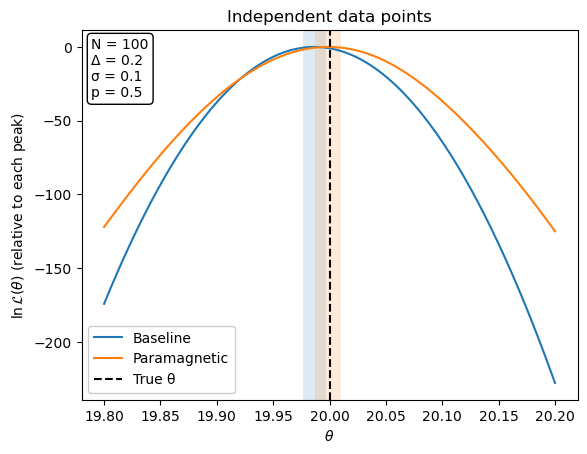

In [7]:
# ============================================================
# PLOT: LOG-LIKELIHOOD
# ============================================================

### Generate data ###
N, theta_true, Delta, sigma, p = 100, 20.0, 0.2, 0.1, 0.5 # set parameters
y, s_true, C, C_fac = generate_data_indep(N, theta_true, Delta, sigma, p)

### Compute log-likelihood ###
theta_arr = np.linspace(theta_true - 0.2, theta_true + 0.2, 200)

LL_baseline = np.array([baseline_loglike(y, C_fac, C, theta) for theta in theta_arr])
LL_paramag  = np.array([LL_baseline[i] + Delta_loglike_paramag(y, C_fac, C, Delta, p, theta)
                        for i, theta in enumerate(theta_arr)])

LLb_rel = LL_baseline - LL_baseline.max() # normalize: subtract each curve’s own maximum
LLp_rel = LL_paramag  - LL_paramag.max()

### MLE and CIs ###
_, lo_b, hi_b = mle_and_ci_1d(theta_arr, LLb_rel, delta=0.5) # Compute 68% CIs (ΔlnL = 0.5)
_, lo_p, hi_p = mle_and_ci_1d(theta_arr, LLp_rel, delta=0.5)

### Plot ###
fig, ax = plt.subplots()

line_b, = ax.plot(theta_arr, LLb_rel, label="Baseline")
line_p, = ax.plot(theta_arr, LLp_rel, label="Paramagnetic")
ax.axvline(theta_true, color='k', ls='--', label="True θ")

if np.isfinite(lo_b) and np.isfinite(hi_b):
    ax.axvspan(lo_b, hi_b, color=line_b.get_color(), alpha=0.15, linewidth=0, label="_nolegend_")
if np.isfinite(lo_p) and np.isfinite(hi_p):
    ax.axvspan(lo_p, hi_p, color=line_p.get_color(), alpha=0.15, linewidth=0, label="_nolegend_")

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\ln \mathcal{L}(\theta)$ (relative to each peak)")
ax.set_title("Independent data points")
ax.legend(facecolor='white', framealpha=1.0)

param_text = (f"N = {N}\nΔ = {Delta}\nσ = {sigma}\np = {p}")
ax.text(0.02, 0.98, param_text, transform=ax.transAxes, ha="left", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=1.0))

plt.show()


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 122.09it/s]


Converged: True
emcee finished in 81.9 sec with 10000 iterations
100 x autocorrelation time = 5078.6


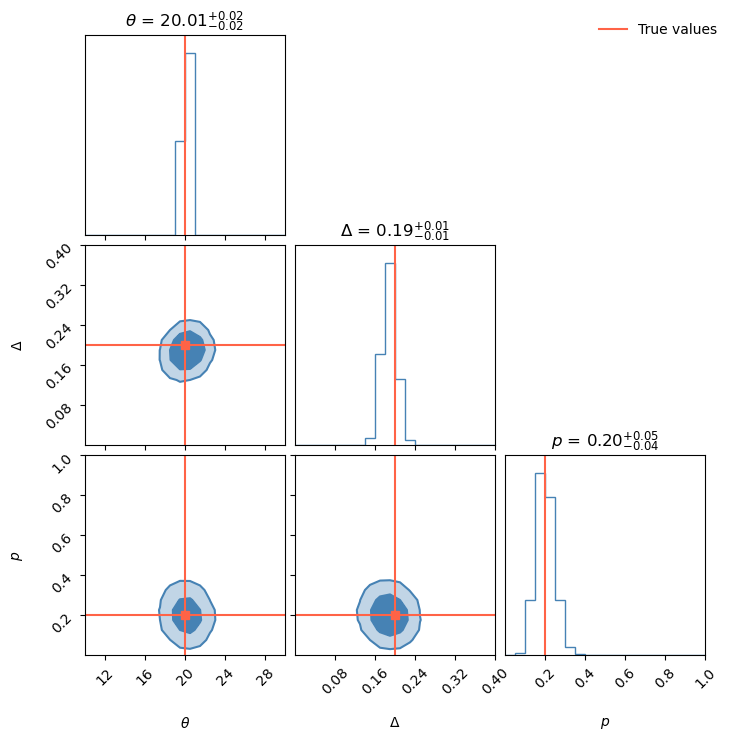

In [8]:
# ============================================================
# MCMC: INFERRING Delta AND p
# ============================================================

### Settings ###
N, theta_true, Delta, sigma, p = 100, 20.0, 0.2, 0.1, 0.2
max_n = 10**4 # no. max iterations
nwalk = 4*3 # no. walkers
mymove = emcee.moves.StretchMove() # moves


### Priors ###
temp_min = 10.0
temp_max = 30.0
Delta_min = 0.0
Delta_max = 2. * Delta
p_min = 0.0
p_max = 1.0

priors = np.array([[temp_min, temp_max], [Delta_min, Delta_max], [p_min, p_max]])


### Initial guess for each walker ###
ndim = len(priors)
theta0 = np.random.uniform(priors[:, 0], priors[:, 1], size=(nwalk, ndim))


### Prepare log-prob ###
y, s_true, C, C_fac = generate_data_indep(N, theta_true, Delta, sigma, p)

def log_prior(theta):
    if np.any(theta <= priors[:, 0]) or np.any(theta >= priors[:, 1]):
        return -np.inf    
    else:
        return 1

def log_like(theta):
    temp, Delta, p = theta
    baseline = baseline_loglike(y, C_fac, C, temp)
    corr = Delta_loglike_paramag(y, C_fac, C, Delta, p, temp)
    tot = baseline + corr
    return tot

def log_prob(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return log_like(theta)


### Run MCMC ###
start = time.time()
sampler = emcee.EnsembleSampler(nwalk, ndim, log_prob, moves = mymove)
sampler.run_mcmc(theta0, nsteps = max_n, progress = True) # skip_initial_state_check=True
end = time.time()
    
tau = sampler.get_autocorr_time(tol=0)
autocorr = np.max(tau)

burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchain = sampler.get_chain(discard=burnin, flat=True, thin=thin)


### Diagnostics ###
run_time = end - start
if max_n > (100. * autocorr):
    print('Converged: True')
else:
    print('Converged: False')
print('emcee finished in %.1f sec with %.0f iterations' % (run_time, max_n))
print('100 x autocorrelation time = %.1f' % (100. * autocorr))


### Plot posterior ###
fig = corner.corner(
    flatchain,
    range = priors,
    levels = [0.68, 0.95], # credence regions
    show_titles = True,
    plot_datapoints = False,
    fill_contours = True,
    smooth = 1.0,
    color = 'steelblue',
    title_fmt = '.2f',
    title_kwargs = {"fontsize": 12},
    labels=[r'$\theta$', r'$\Delta$', r'$p$'],
    truths=[theta_true, Delta, p],
    truth_color='tomato')

proxy = mlines.Line2D([], [], color="tomato", label="True values")

fig.legend(handles=[proxy], loc="upper right", frameon=False, bbox_to_anchor=(0.98, 0.98))

plt.show()


## Case B: Correlated data
Correlations induce off-diagonal couplings and we use the mean-field approximation.

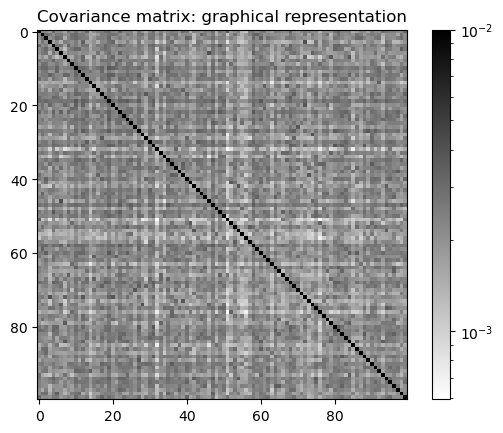

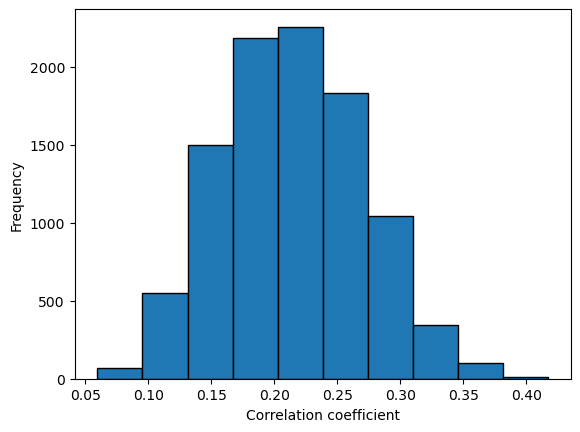

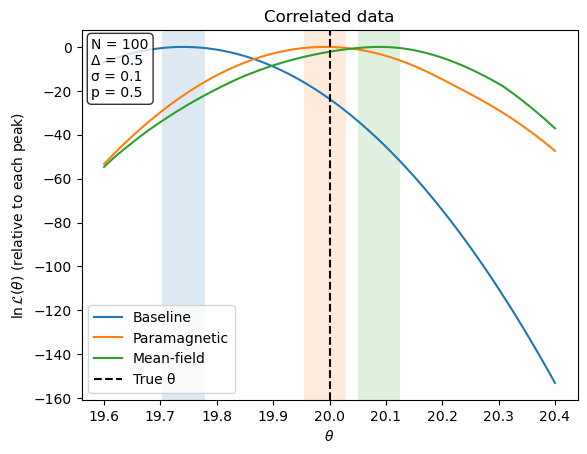

In [9]:
# ===================================================================
# PLOT: LOG-LIKELIHOOD
# ===================================================================

### Generate data ###
N, theta_true, Delta, sigma, p = 100, 20.0, 0.5, 0.1, 0.5 # set parameters
y, s_true, C, C_fac = generate_data_corr(N, theta_true, Delta, sigma, p)

# Plot covariance matrix
plt.imshow(C, cmap='gray_r', interpolation='none', norm=LogNorm())
plt.colorbar()
plt.title('Covariance matrix: graphical representation')
plt.show()

# Plot correlation coefficients
R = cov_to_corr(C) # covariance -> correlation matrix
non_diag = R[~np.eye(R.shape[0], dtype=bool)]

plt.hist(non_diag, edgecolor='black')
plt.xlabel("Correlation coefficient")
plt.ylabel("Frequency")
plt.show()


### Compute log-likelihood ###
theta_arr = np.linspace(theta_true - 0.4, theta_true + 0.4, 200)

LL_baseline = np.array([baseline_loglike(y, C_fac, C, theta) for theta in theta_arr])
LL_paramag  = np.array([LL_baseline[i] + Delta_loglike_paramag(y, C_fac, C, Delta, p, theta)
                        for i, theta in enumerate(theta_arr)])

LL_mf = np.empty_like(theta_arr)
u_prev = None
for i, theta in enumerate(theta_arr):
    dlogL_mf, u_prev, _m = Delta_loglike_meanfield(y, C_fac, C, Delta, p, theta, u0=u_prev,
                                                   tol=1e-10, maxiter=300, use_homotopy=True) # set homotopy to True if you hit tough cases
    LL_mf[i] = LL_baseline[i] + dlogL_mf

LLb_rel  = LL_baseline - LL_baseline.max() # normalize (relative to each curve’s own peak)
LLp_rel  = LL_paramag  - LL_paramag.max()
LLmf_rel = LL_mf       - LL_mf.max()


### MLE and CIs ###
_, lo_b,  hi_b  = mle_and_ci_1d(theta_arr, LLb_rel,  delta=0.5) # 68% CIs (ΔlnL = 0.5) from the relative curves
_, lo_p,  hi_p  = mle_and_ci_1d(theta_arr, LLp_rel,  delta=0.5)
_, lo_mf, hi_mf = mle_and_ci_1d(theta_arr, LLmf_rel, delta=0.5)


### Plot ###
fig, ax = plt.subplots()

line_b,  = ax.plot(theta_arr, LLb_rel,  label="Baseline")
line_p,  = ax.plot(theta_arr, LLp_rel,  label="Paramagnetic")
line_mf, = ax.plot(theta_arr, LLmf_rel, label="Mean-field")
ax.axvline(theta_true, color='k', ls='--', label="True θ")

if np.isfinite(lo_b) and np.isfinite(hi_b):
    ax.axvspan(lo_b,  hi_b,  color=line_b.get_color(),  alpha=0.15, linewidth=0, label="_nolegend_")
if np.isfinite(lo_p) and np.isfinite(hi_p):
    ax.axvspan(lo_p,  hi_p,  color=line_p.get_color(),  alpha=0.15, linewidth=0, label="_nolegend_")
if np.isfinite(lo_mf) and np.isfinite(hi_mf):
    ax.axvspan(lo_mf, hi_mf, color=line_mf.get_color(), alpha=0.15, linewidth=0, label="_nolegend_")

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\ln \mathcal{L}(\theta)$ (relative to each peak)")
ax.set_title(r"Correlated data")
ax.legend()

param_text = (f"N = {N}\nΔ = {Delta}\nσ = {sigma}\np = {p}")
ax.text(0.02, 0.98, param_text, transform=ax.transAxes, ha="left", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()
